In [15]:
%run core.ipynb

from xmeos import models
from xmeos import eoslib


In [16]:
from xmeos.eoslib import get_oxide_data, calc_comp_details
from xmeos.models import core

In [17]:
T = 4250
P = np.linspace(0,136,301)

In [18]:
# NOTE: There is potentially a problem here with the mol fractions,
#   whether they are on a formula basis or an atomic basis
# Need to clarify this !

meltcomp_mant = {'En':62, 'Fo':24, 'Fa':8, 'An':4, 'Di':2}
eos_mod_mant = eoslib.CMASF_melt_Thomas2013(meltcomp_mant)

meltcomp_en = {'En':100}
eos_mod_en = eoslib.CMASF_melt_Thomas2013(meltcomp_en)

meltcomp_perid = {'En':32.7, 'Fo':56.1, 'Fa':7.2, 'An':3.3, 'Di':.7}
eos_mod_perid = eoslib.CMASF_melt_Thomas2013(meltcomp_perid)


V_mant = eos_mod_mant.volume(P, T)
V_en = eos_mod_en.volume(P, T)
V_perid = eos_mod_perid.volume(P, T)

In [69]:
oxide_comp = ['CaO', 'MgO', 'Al2O3', 'SiO2', 'FeO']

# CMASF-Fa-model
liquid_endmem = ['En', 'Fo', 'Fa', 'An', 'Di']
stoich = np.array([
    [0,1,0,1,0],
    [0,2,0,1,0],
    [0,0,0,1,2],
    [1,0,1,2,0],
    [1,1,0,2,0]]
)


# CMASF-AnDiHd-model
liquid_endmem = ['En', 'Fo', 'AnDiHd', 'An', 'Di']
stoich = np.array([
    [0,1,0,1,0],
    [0,2,0,1,0],
    [1,1./3,1./3,2,1./3],
    [1,0,1,2,0],
    [1,1,0,2,0]]
)


In [70]:
comp_cat = np.array([2.53, 49.81, 3.51, 38.02, 5.64])
oxide_cat_num = np.array([1, 1, 2, 1, 1])
comp_ox = comp_cat/oxide_cat_num
comp_ox *= 100/np.sum(comp_ox)
display(comp_ox)
# comp_ox = comp_ox-11.503*np.array([0,1,0,1,0])
display(comp_ox)

output = np.linalg.lstsq(stoich.T, comp_ox)
endmem_comp = output[0]
endmem_comp *= 100/np.sum(endmem_comp)
display(np.round(endmem_comp, decimals=2))

array([ 2.58810291, 50.9539154 ,  1.79530459, 38.89315125,  5.76952586])

array([ 2.58810291, 50.9539154 ,  1.79530459, 38.89315125,  5.76952586])

/Users/aswolf/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


array([ 31.68,  61.19,  47.68, -10.95, -29.6 ])

In [41]:
comp_cat = np.array([10.56, 49.21, 14.65, 0.00, 23.54])
oxide_cat_num = np.array([1, 1, 2, 1, 1])
comp_ox = comp_cat/oxide_cat_num
comp_ox *= 100/np.sum(comp_ox)
display(comp_ox)

output = np.linalg.lstsq(stoich.T, comp_ox)
endmem_comp = output[0]
endmem_comp *= 100/np.sum(endmem_comp)
display(endmem_comp)



array([11.65112815, 54.29469852,  8.08186683,  0.        , 25.9723065 ])

/Users/aswolf/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


array([1058.28598485, -746.82765152, -111.45833333,  -69.3655303 ,
        -30.6344697 ])

In [ ]:
meltcomp_mant = {'En':62, 'Fo':24, 'Fa':8, 'An':4, 'Di':2}
meltcomp_perid = {'En':32.7, 'Fo':56.1, 'Fa':7.2, 'An':3.3, 'Di':.7}

<IPython.core.display.Javascript object>


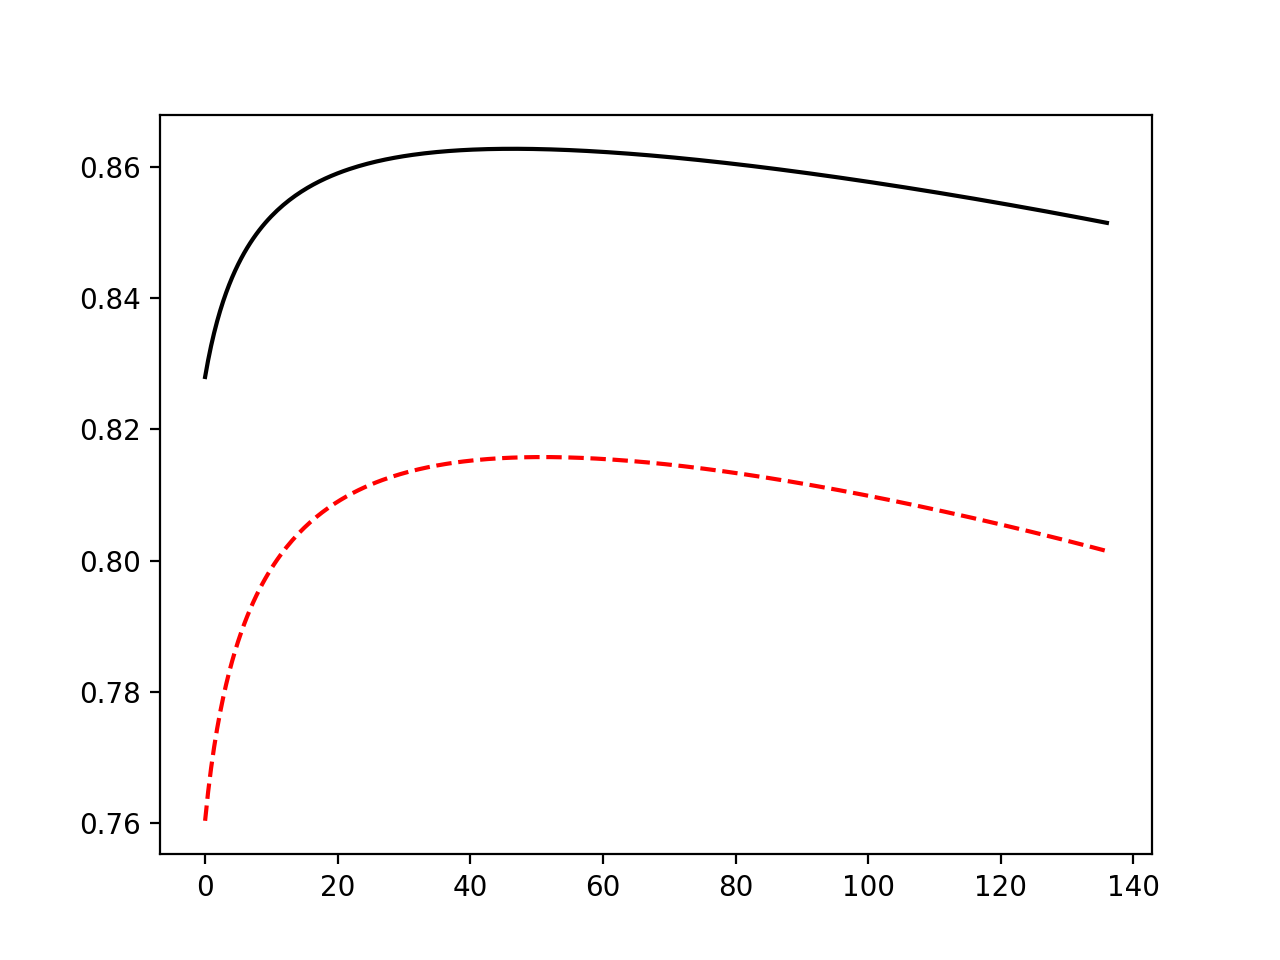

<IPython.core.display.Javascript object>


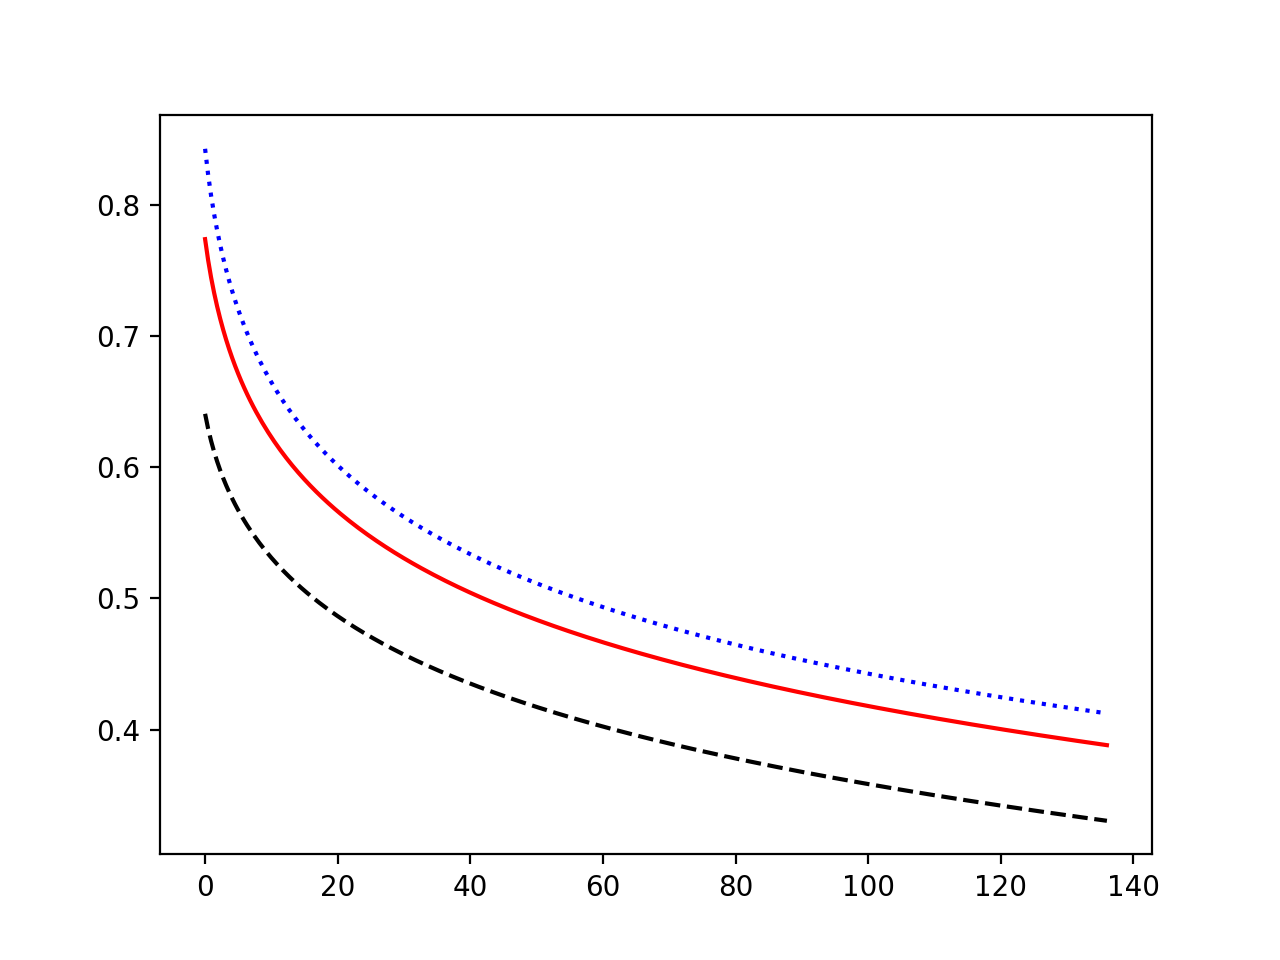

In [13]:

plt.figure()
plt.plot(P, V_en/V_mant, 'k-')
plt.plot(P, V_en/V_perid, 'r--')

plt.figure()
plt.plot(P, V_mant, 'r-', P, V_en, 'k--', P, V_perid, 'b:')

In [3]:

# tait_eos = xmeos.models.CompressEos(kind='Tait')
def Tait_vol(P, V0, K0, KP0, KP20=None):
    if KP20 is None:
        KP20 = -KP0/K0
    
    a = (KP0 + 1)/(K0*KP20 + KP0 + 1)
    b = -KP20/(KP0+1) + KP0/K0
    c = (K0*KP20 + KP0 + 1)/(-K0*KP20 + KP0**2 + KP0)

    V = V0*(1-a*(1-(1+b*P)**(-c)))
    return V


def volume(P, T, eos_mod, Niter=10):
    V0, K0, KP0 = eos_mod.get_param_values(param_names=['V0','K0','KP0'])
    
    KP20 = eos_mod.param_values[eos_mod.param_names=='KP20'] if ('KP20' in eos_mod.param_names) else None
    
    V = Tait_vol(P, V0, K0, KP0, KP20=KP20)
    P_mod = eos_mod.press(V, T)
    
    
    for iter in range(Niter):
        K = eos_mod.bulk_mod(V, T)
        P_mod = eos_mod.press(V, T)
        dPdV = -K/V
        dP = P_mod-P
        dV_frac = -dP/dPdV/V
        V *= np.exp(dV_frac)
        
    P_mod = eos_mod.press(V, T)
    return V


In [3]:

oxide_data = get_oxide_data()
comp_d = calc_comp_details({'MgO':1,'SiO2':1}, kind='mol')

rho0 = 2.617
V0 = comp_d['molmass']/rho0*core.CONSTS['ang3percc']/core.CONSTS['Nmol']

natom=1
Cv_J_kg_K = 1690.53
ndof = 6
Cvlim = ndof/2*core.CONSTS['R']
Cv = Cv_J_kg_K*1e-3*comp_d['molmass']/natom # J/mol/K
Cvlimfac = Cv/Cvlim

# Normalize to a single atom basis
V0 /= natom

eos_mod = models.MieGruneisenEos(
    kind_thermal='ConstHeatCap', kind_gamma='GammaPowLaw',
    kind_compress='BirchMurn4', compress_path_const='S',
    natom=natom)
ref_state = eos_mod.refstate.ref_state
ref_state['T0'] = 1673

eos_mod.ndof = ndof
eos_mod.set_param_values([V0], param_names=['V0'])
eos_mod.set_param_values([0.365,-0.88], param_names=['gamma0','q'])
eos_mod.set_param_values([24.66, 10.07, -2.35], param_names=['K0','KP0','KP20'])
eos_mod.set_param_values([Cvlimfac], param_names=['Cvlimfac'])


<IPython.core.display.Javascript object>


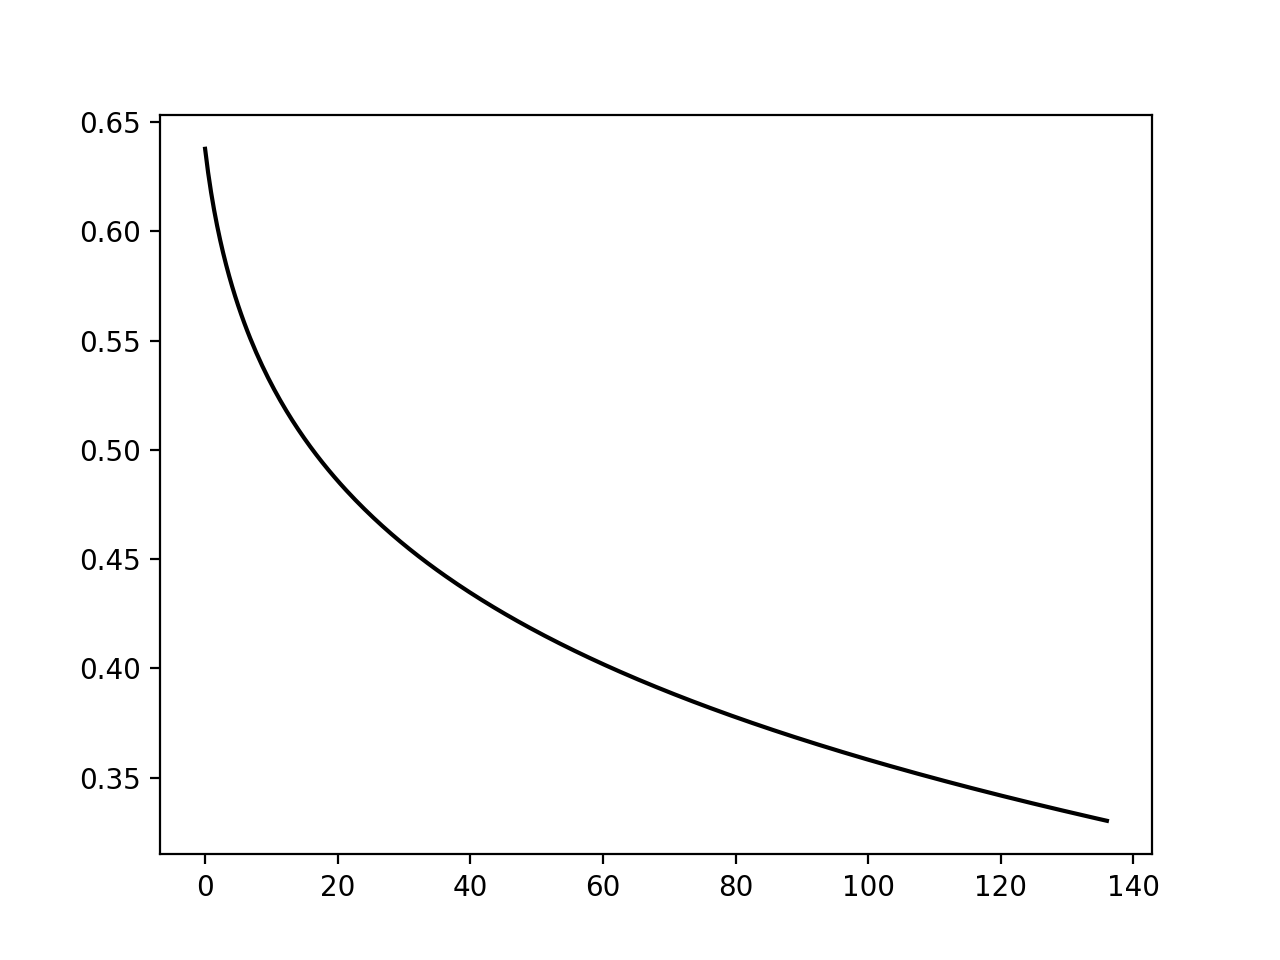

In [5]:
T = 2273
P = np.linspace(0,136,301)

V = eos_mod.volume(P, T)

plt.figure()
plt.plot(P, V, 'k-')

In [31]:
oxide_data = get_oxide_data()
comp_d = calc_comp_details({'MgO':2,'SiO2':1}, kind='mol')

rho0 = 2.597
V0 = comp_d['molmass']/rho0*core.CONSTS['ang3percc']/core.CONSTS['Nmol']

natom=1
Cv_J_kg_K = 1737.36
ndof = 6
Cvlim = ndof/2*core.CONSTS['R']
Cv = Cv_J_kg_K*1e-3*comp_d['molmass']/natom # J/mol/K
Cvlimfac = Cv/Cvlim

# Normalize to a single atom basis
V0 /= natom

eos_mod = models.MieGruneisenEos(
    kind_thermal='ConstHeatCap', kind_gamma='GammaPowLaw',
    kind_compress='BirchMurn3', compress_path_const='S',
    natom=natom)
ref_state = eos_mod.refstate.ref_state
ref_state['T0'] = 2273

eos_mod.ndof = ndof
eos_mod.set_param_values([V0], param_names=['V0'])
eos_mod.set_param_values([0.396,-2.02], param_names=['gamma0','q'])
eos_mod.set_param_values([16.41, 7.37], param_names=['K0','KP0'])
eos_mod.set_param_values([Cvlimfac], param_names=['Cvlimfac'])



<IPython.core.display.Javascript object>


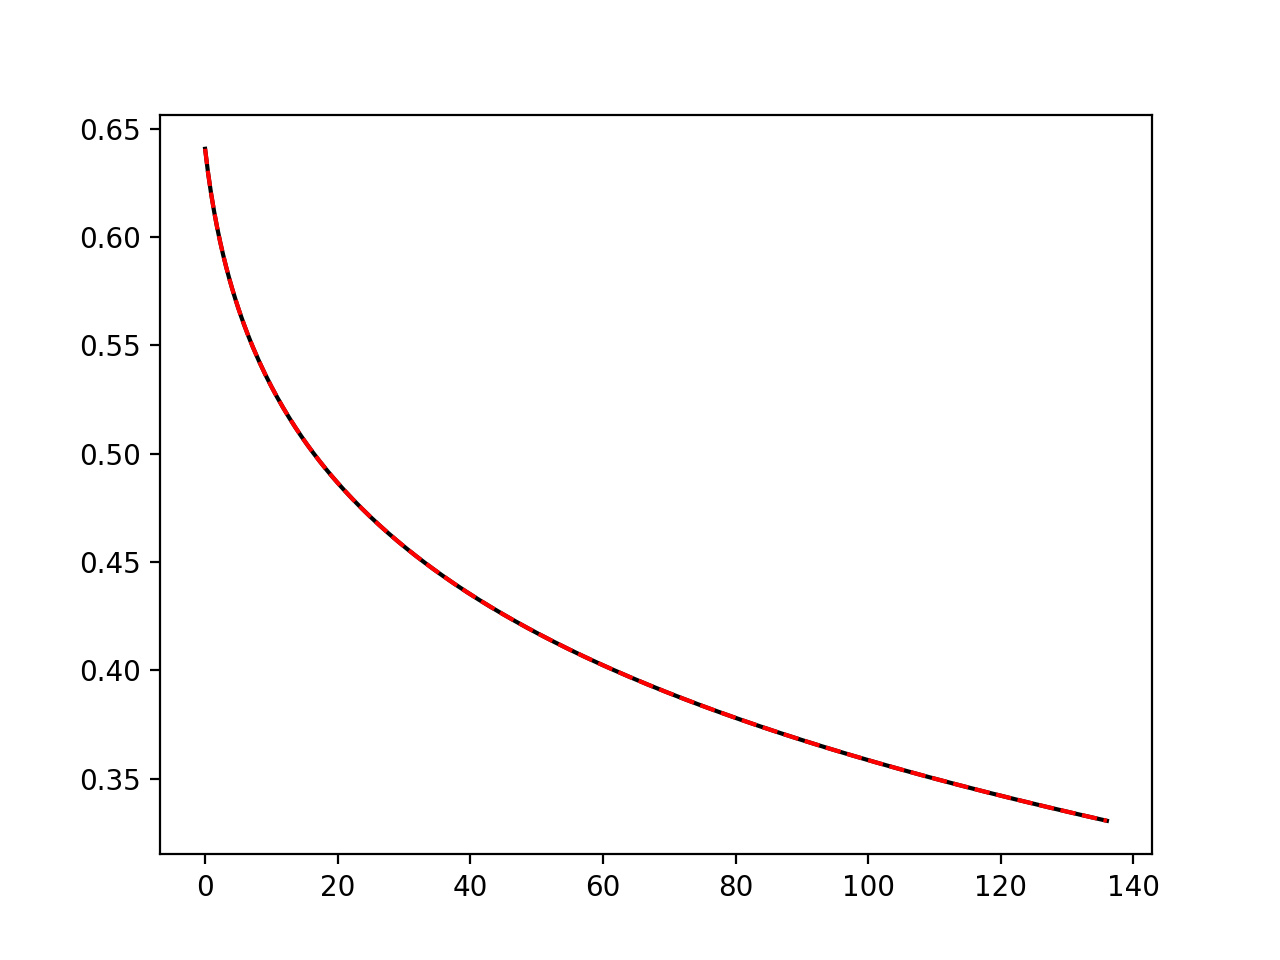

In [61]:
T = 2273
T = 4273
# P = np.linspace(0,300,3001)
# P = np.linspace(0,100,301)
# P = np.linspace(0,300,301)
# P = np.linspace(0,280,301)
P = np.linspace(0,136,301)

V = volume(P, T, eos_mod, Niter=10)
P_mod = eos_mod.press(V, T)

plt.figure()
plt.plot(P_mod, V, 'k-', P, V, 'r--')
# plt.xlim(-10,1000)

In [26]:
eos_mod.param_values[eos_mod.param_names=='KP20']

array([-2.35])

In [19]:

# meltcomp = {'En':62, 'Fo':24, 'Fa':8, 'An':4, 'Di':2}
meltcomp = {'En':100, 'Fo':0, 'Fa':0, 'An':0, 'Di':0}
eos_mod = eoslib.CMASF_melt_Thomas2013(meltcomp, kind='endmem')
P_a = np.linspace(5,135,51)
# P_a = np.array([5,25,50,75,100,125])
T = 4000
# V_a = volume( volume(P, T, eos_mod, Vinit=None, TOL=1e-3, bounds_error=True))
V_a = np.array([eos_mod.volume(iP, T) for iP in P_a])



AttributeError: 'CMASF_melt_Thomas2013' object has no attribute '_calculators'

In [22]:
eos_mod.press(1, T)

AttributeError: 'CMASF_melt_Thomas2013' object has no attribute '_calculators'

<IPython.core.display.Javascript object>


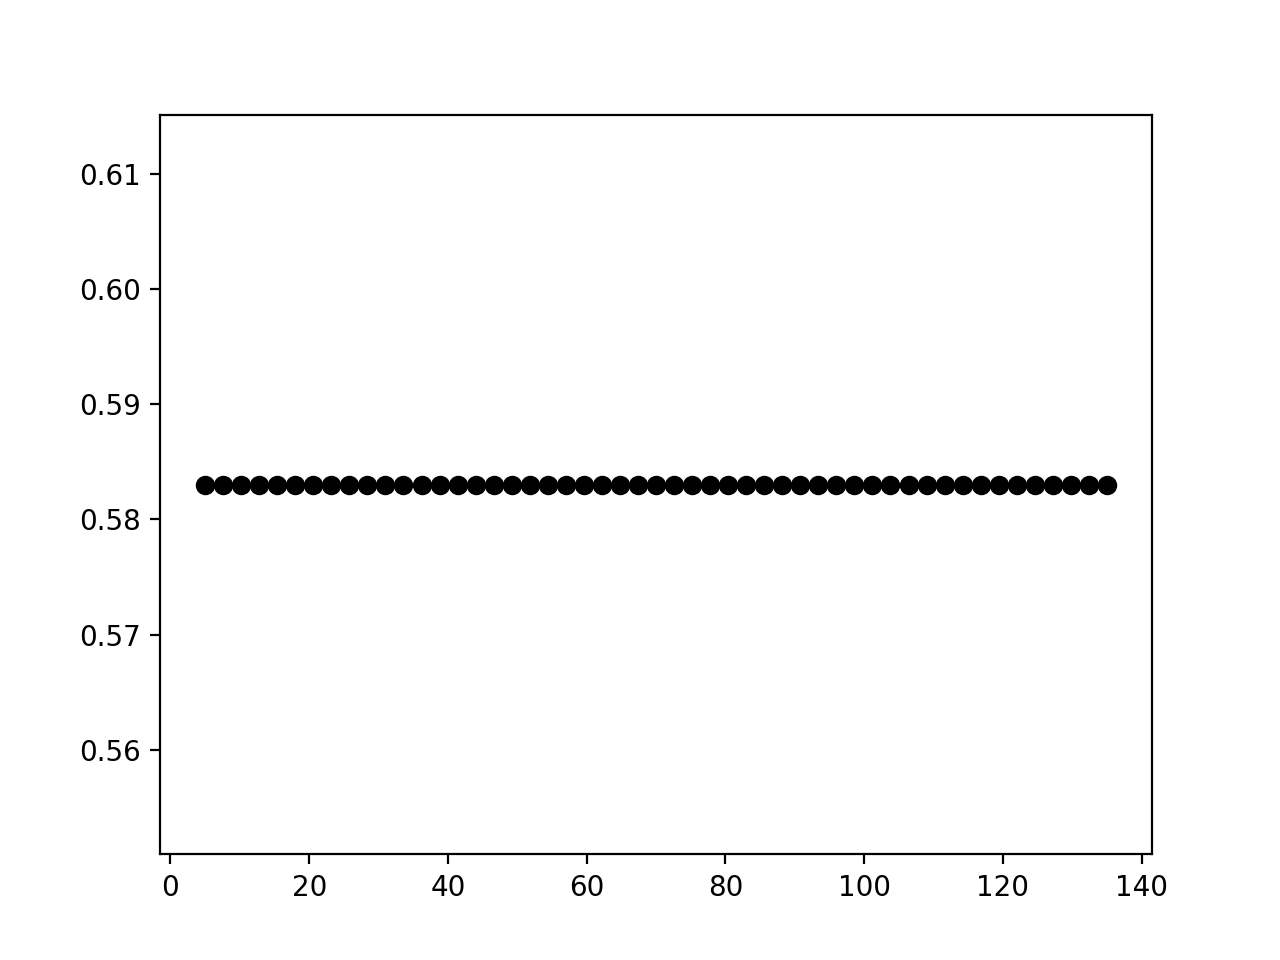

In [13]:
plt.plot(P_a, V_a, 'k-o')